In [1]:
# Install the Prophet
!pip install prophet

In [2]:
# Import the required libraries and dependencies
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from prophet import Prophet
import yfinance as yf
import os
import csv

In [3]:
import warnings
# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
# Set crypto variable
crypto = 'WIF'
yf_crypto = 'WIF'

# Set YF crypto symbol
symbol = f'{yf_crypto}-USD'

# Create crypto df
#crypto_df = f'{crypto}_df'.lower()

In [5]:
# Retreive max data
data = yf.Ticker(f'{symbol}')
history = data.history(period='max')

# Define file path and name
#filepath = f'~/crypto-forecast/resources/{crypto}-USD.csv'
#filepath = os.path.expanduser('~/crypto-forecast/resources/ADA-USD.csv')

# Create dataframe
crypto_df = pd.DataFrame(history)

# Set 'Date' as the index and parse dates
crypto_df.index = pd.to_datetime(crypto_df.index)

# Drop columns
crypto_df.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

# Drop last row
crypto_df = crypto_df.drop(crypto_df.tail(1).index)

# Drop rows with any NaN values
crypto_df.dropna(inplace=True)

# Sort by ascending date
crypto_df = crypto_df.sort_values(by="Date", ascending=True)

# Drop timezone from datetime
crypto_df = crypto_df.reset_index()
crypto_df['Date'] = crypto_df['Date'].dt.tz_localize(None)
crypto_df.set_index('Date', inplace=True)

# Set file path to store data as a csv
csv_filepath = os.path.expanduser(f'~/crypto-forecast/resources/{crypto}-USD.csv')

# Write the DataFrame to a CSV file
crypto_df.to_csv(csv_filepath, index=True)

# Review the first and last five rows of the DataFrame
display(crypto_df.head())
display(crypto_df.tail())

,Open,High,Low,Close,Volume
Date,,,,,
2023-12-19,0.168051,0.208053,0.136873,0.146876,122808844
2023-12-20,0.145942,0.210890,0.105023,0.186058,111016061
2023-12-21,0.185669,0.293065,0.184070,0.280936,113313578
2023-12-22,0.282465,0.331251,0.217143,0.226059,68356381
2023-12-23,0.227300,0.247010,0.132518,0.234329,150550688


,Open,High,Low,Close,Volume
Date,,,,,
2024-06-04,3.267746,3.495653,3.205808,3.405245,544657145
2024-06-05,3.405215,3.577263,3.366188,3.393645,613998518
2024-06-06,3.393645,3.448607,3.229098,3.229098,437746946
2024-06-07,3.229098,3.327717,2.655769,2.859470,814630778
2024-06-08,2.858863,2.928864,2.659932,2.710416,492445224


In [6]:
# Get last closing price
last_close_df = crypto_df.iloc[-1]
last_close_price = last_close_df['Close']
last_close_price

2.710416078567505

In [7]:
crypto_df.corr()

,Open,High,Low,Close,Volume
Open,1.000000,0.992815,0.994254,0.986426,0.807352
High,0.992815,1.000000,0.992108,0.995394,0.841443
Low,0.994254,0.992108,1.000000,0.992969,0.792594
Close,0.986426,0.995394,0.992969,1.000000,0.824022
Volume,0.807352,0.841443,0.792594,0.824022,1.000000


In [8]:
# Create new df with just Close prices and Volume
df_close = crypto_df[['Close', 'Volume']]

In [9]:
df_close.name = 'Close'
df_close

,Close,Volume
Date,,
2023-12-19,0.146876,122808844
2023-12-20,0.186058,111016061
2023-12-21,0.280936,113313578
2023-12-22,0.226059,68356381
2023-12-23,0.234329,150550688
...,...,...
2024-06-04,3.405245,544657145
2024-06-05,3.393645,613998518
2024-06-06,3.229098,437746946


In [10]:
# Create a copy of the DataFrame to avoid the SettingWithCopyWarning
df_close_ma = df_close.copy()

# Calculate volatility
df_close_ma.loc[:, 'Percent Change'] = df_close_ma['Close'].pct_change()*100
df_close_ma.loc[:, 'Volatility'] = df_close_ma['Percent Change'].rolling(10).std(ddof=0) * np.sqrt(252)

# Calculate 10-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA10'] = df_close_ma['Close'].rolling(10).mean()

# Calculate 30-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA30'] = df_close_ma['Close'].rolling(30).mean()

# Calculate 50-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA50'] = df_close_ma['Close'].rolling(50).mean()

# Remove NULL values
df_close_ma.dropna(inplace=True)

In [11]:
# Review the first and last five rows of the DataFrame
display(df_close_ma.head())
display(df_close_ma.tail())

,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2024-02-06,0.190114,27773843,0.252364,0.279961,0.233768
2024-02-07,0.215870,60730494,0.240875,0.282790,0.235148
2024-02-08,0.219426,45729690,0.231454,0.285781,0.235815
2024-02-09,0.249959,42386176,0.228245,0.288323,0.235196
2024-02-10,0.316881,56427892,0.234805,0.289637,0.237012


,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2024-06-04,3.405245,544657145,3.363270,3.063831,2.985307
2024-06-05,3.393645,613998518,3.407495,3.064950,2.999512
2024-06-06,3.229098,437746946,3.390115,3.072429,3.015696
2024-06-07,2.859470,814630778,3.298248,3.075053,3.021456
2024-06-08,2.710416,492445224,3.202024,3.061375,3.017053


<Axes: xlabel='Date'>

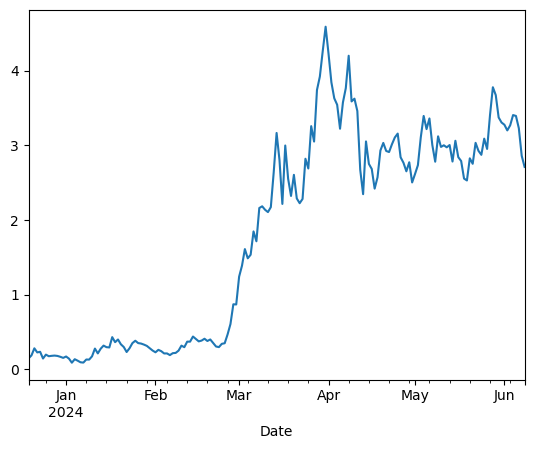

In [12]:
# Plot Close
df_close['Close'].plot()

In [13]:
## Create a Time Series Model with Prophet

In [14]:
# Using the DataFrame, reset the index so the date information is no longer the index
df_close = df_close.reset_index()

In [15]:
# Label the columns ds and y so that the syntax is recognized by Prophet
df_close.rename(columns={'Date':'ds','Close':'y'}, inplace=True)

# Drop an NaN values from the prophet_df DataFrame
df_close.dropna()

# View the first and last five rows of the DataFrame
df_close

,ds,y,Volume
0,2023-12-19,0.146876,122808844
1,2023-12-20,0.186058,111016061
2,2023-12-21,0.280936,113313578
3,2023-12-22,0.226059,68356381
4,2023-12-23,0.234329,150550688
...,...,...,...
168,2024-06-04,3.405245,544657145
169,2024-06-05,3.393645,613998518
170,2024-06-06,3.229098,437746946
171,2024-06-07,2.859470,814630778


In [16]:
# Call the Prophet function, store as an object
crypto_model = Prophet()

In [17]:
# Fit the time-series model.
crypto_model.fit(df_close)

17:07:53 - cmdstanpy - INFO - Chain [1] start processing
17:07:53 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Create a future dataframe to hold predictions
# Make the prediction go out 30 days
crypto_future = crypto_model.make_future_dataframe(periods = 90, freq = 'd')

# View the last five rows of the DataFrame
crypto_future.tail(5)

,ds
258,2024-09-02
259,2024-09-03
260,2024-09-04
261,2024-09-05
262,2024-09-06


In [19]:
# Make the predictions for the data using the DataFrame
crypto_forecast = crypto_model.predict(crypto_future)

# Display the first five rows of the DataFrame
crypto_forecast.tail(30)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
233,2024-08-08,3.111942,2.317088,3.952500,2.448259,3.805055,0.020492,0.020492,0.020492,0.020492,0.020492,0.020492,0.0,0.0,0.0,3.132434
234,2024-08-09,3.112027,2.195864,3.958662,2.437133,3.819613,-0.034590,-0.034590,-0.034590,-0.034590,-0.034590,-0.034590,0.0,0.0,0.0,3.077437
235,2024-08-10,3.112112,2.148991,3.960087,2.425512,3.838398,-0.044090,-0.044090,-0.044090,-0.044090,-0.044090,-0.044090,0.0,0.0,0.0,3.068023
236,2024-08-11,3.112198,2.241895,4.062846,2.413689,3.857957,0.031617,0.031617,0.031617,0.031617,0.031617,0.031617,0.0,0.0,0.0,3.143814
237,2024-08-12,3.112283,2.173421,4.110561,2.399252,3.881719,0.025904,0.025904,0.025904,0.025904,0.025904,0.025904,0.0,0.0,0.0,3.138187
238,2024-08-13,3.112368,2.160445,4.066179,2.381472,3.892553,-0.017715,-0.017715,-0.017715,-0.017715,-0.017715,-0.017715,0.0,0.0,0.0,3.094653
239,2024-08-14,3.112453,2.173965,4.035641,2.367086,3.907804,0.018383,0.018383,0.018383,0.018383,0.018383,0.018383,0.0,0.0,0.0,3.130836
240,2024-08-15,3.112538,2.158002,4.092657,2.355522,3.922923,0.020492,0.020492,0.020492,0.020492,0.020492,0.020492,0.0,0.0,0.0,3.133030
241,2024-08-16,3.112624,2.155870,4.096033,2.342020,3.940824,-0.034590,-0.034590,-0.034590,-0.034590,-0.034590,-0.034590,0.0,0.0,0.0,3.078033
242,2024-08-17,3.112709,2.121057,4.084397,2.328493,3.958506,-0.044090,-0.044090,-0.044090,-0.044090,-0.044090,-0.044090,0.0,0.0,0.0,3.068619


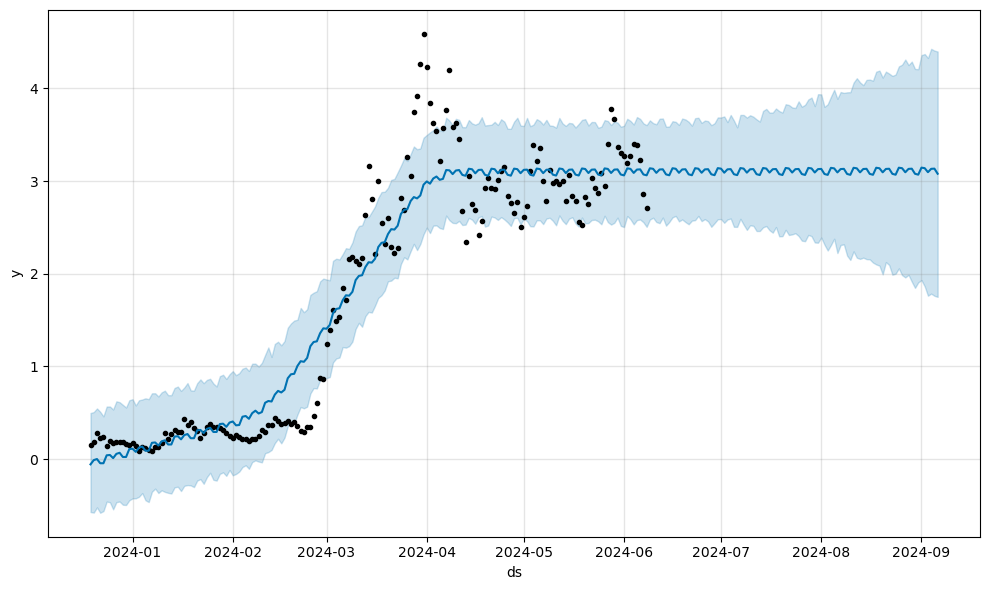

In [20]:
# Plot the Prophet predictions for the data
crypto_model.plot(crypto_forecast)
plt.savefig(f'{crypto}_forecast', bbox_inches = 'tight')

In [21]:
# Set the index in the forecast DataFrame to the ds datetime column
crypto_forecast = crypto_forecast.set_index('ds')

In [22]:
# View only the yhat,yhat_lower and yhat_upper columns from the forecast DataFrame
crypto_forecast[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-90:,:]

,yhat,yhat_lower,yhat_upper
ds,,,
2024-06-09,3.138448,2.585027,3.655850
2024-06-10,3.132820,2.604736,3.626080
2024-06-11,3.089286,2.558944,3.613852
2024-06-12,3.125469,2.546339,3.673772
2024-06-13,3.127664,2.606755,3.676117
...,...,...,...
2024-09-02,3.139976,1.863516,4.371887
2024-09-03,3.096442,1.763300,4.329133
2024-09-04,3.132625,1.785660,4.427764


In [23]:
# Rename columns
crypto_forecast.rename(columns={'yhat':'mid trend price','yhat_lower':'lower trend price','yhat_upper':'upper trend price'}, inplace=True)

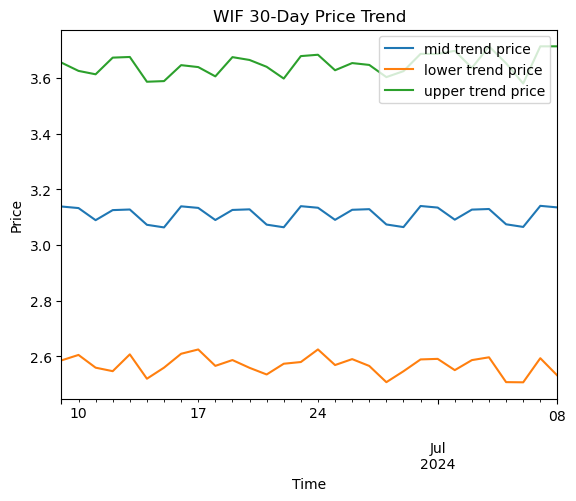

In [24]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-60,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 30-Day Price Trend')    
plt.show()

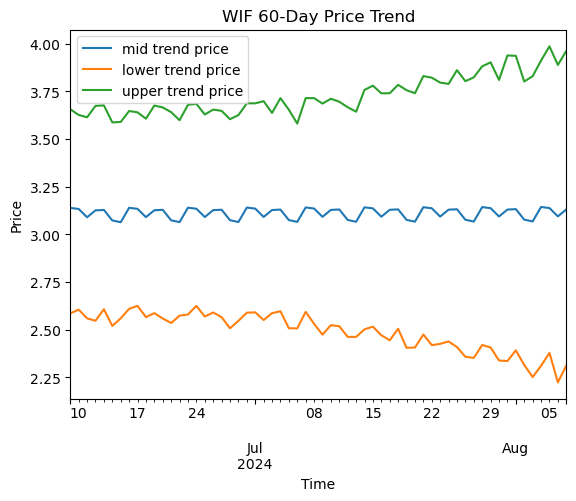

In [25]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-30,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 60-Day Price Trend')    
plt.show()

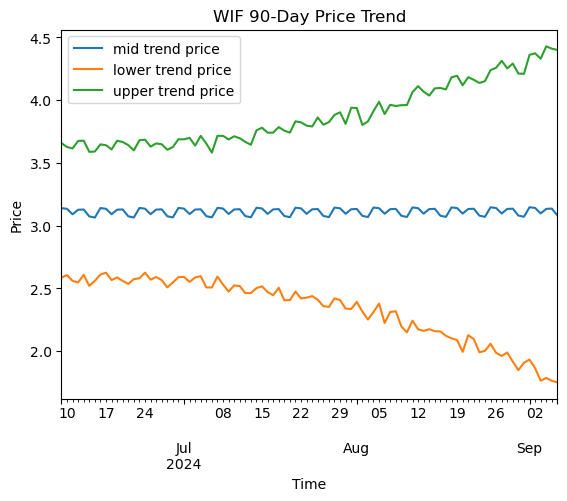

In [26]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 90-Day Price Trend')    
plt.savefig(f'{crypto}_90d_trend_forecast', bbox_inches = 'tight')
plt.show()

In [27]:
# Retrieve last closing price
last_close_price

2.710416078567505

In [28]:
# Retreive tomorrow's mid trend price forecast
tommorow_mid_trend_price = crypto_forecast['mid trend price'].iloc[-90]
tommorow_mid_trend_price

3.1384478059131484

In [29]:
# Calculate tommorrow's weighted price
wp = last_close_price*.5 + tommorow_mid_trend_price*.5
wp

2.924431942240327

In [30]:
# Retreive tomorrow's weighted trend price forecast
tommorow_mid_trend_price = ((crypto_forecast['mid trend price'].iloc[-90]*.6)+(crypto_forecast['upper trend price'].iloc[-90]*.2)+(crypto_forecast['lower trend price'].iloc[-90]*.2))
tommorow_mid_trend_price

3.131244112683518

In [31]:
# Retrieve weighted trend price in 30 days
mid_trend_price_in_30 = ((crypto_forecast['mid trend price'].iloc[-60]*.6)+(crypto_forecast['upper trend price'].iloc[-60]*.2)+(crypto_forecast['lower trend price'].iloc[-60]*.2))
mid_trend_price_in_30

3.0868212380727598

In [32]:
# Retrieve weighted trend price in 60 days
mid_trend_price_in_60 = ((crypto_forecast['mid trend price'].iloc[-30]*.6)+(crypto_forecast['upper trend price'].iloc[-30]*.2)+(crypto_forecast['lower trend price'].iloc[-30]*.2))
mid_trend_price_in_60

3.133378022302794

In [33]:
# Retrieve weighted trend price in 90 days
mid_trend_price_in_90 = ((crypto_forecast['mid trend price'].iloc[-1]*.6)+(crypto_forecast['upper trend price'].iloc[-1]*.2)+(crypto_forecast['lower trend price'].iloc[-1]*.2))
mid_trend_price_in_90

3.07780125819257

In [34]:
# Calculate expected gain/loss between mid trend price in 30 days and last close price
#percent_diff_30 = ((mid_trend_price_in_30)/(last_close_price))-1
percent_diff_30 = ((mid_trend_price_in_30)/(wp))-1
percent_diff_30.round(3)

0.056

In [35]:
# Calculate expected gain/loss between mid trend price in 60 days and last close price
#percent_diff_60 = ((mid_trend_price_in_60)/(last_close_price))-1
percent_diff_60 = ((mid_trend_price_in_60)/(wp))-1
percent_diff_60.round(3)

0.071

In [36]:
# Calculate expected gain/loss between mid trend price in 90 days and last close price
#percent_diff_90 = ((mid_trend_price_in_90)/(last_close_price))-1
percent_diff_90 = ((mid_trend_price_in_90)/(wp))-1
percent_diff_90.round(3)

0.052

In [37]:
# Reset the index in the forecast DataFrame
crypto_forecast = crypto_forecast.reset_index()

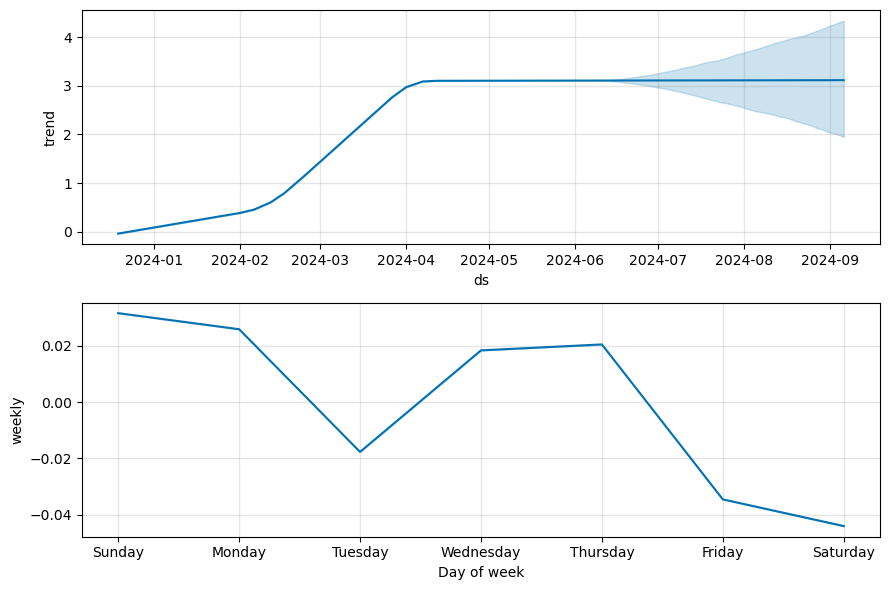

In [38]:
# Use the plot_components function to visualize the forecast results
# for the forecast DataFrame
fig_comp = crypto_model.plot_components(crypto_forecast)
plt.savefig(f'{crypto}_components.png', bbox_inches = 'tight')

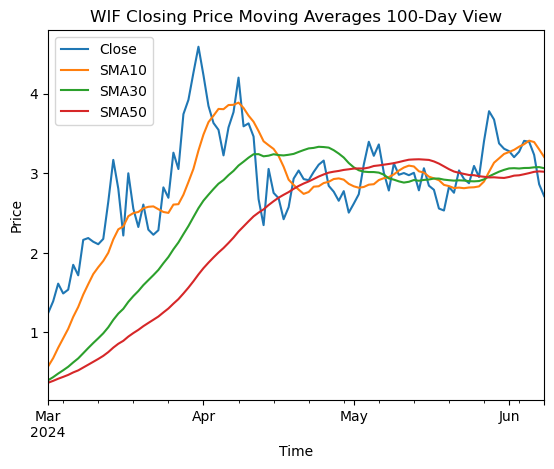

In [39]:
df_last_100 = df_close_ma.iloc[-100:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 100-Day View')    
plt.show()

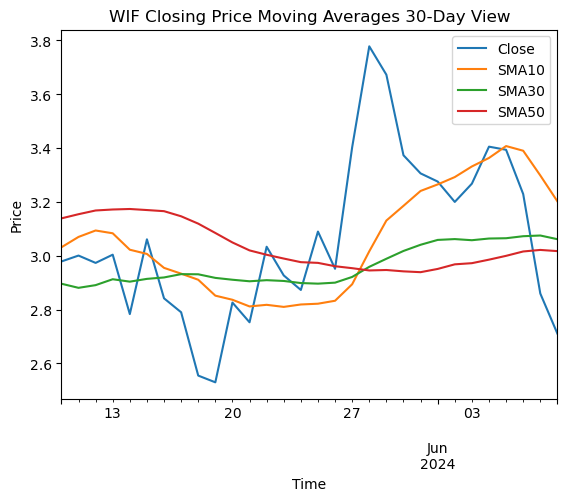

In [40]:
df_last_100 = df_close_ma.iloc[-30:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 30-Day View')    
plt.savefig(f'{crypto}_30d_MA_view.png', bbox_inches = 'tight')
plt.show()

In [41]:
# import module
from datetime import datetime
 
# get current date and time
current_datetime = datetime.now().strftime("%Y-%m-%d")
print("Current date & time : ", current_datetime)
 
# convert datetime obj to string
str_current_datetime = str(current_datetime)
 
# create a file object along with extension
#file_name = f'{crypto} '+str_current_datetime+".txt"
file_name = str_current_datetime+".csv"
file = open(file_name, 'a')
 
print("File created : ", file.name)
file.close()

Current date & time :  2024-06-09
File created :  2024-06-09.csv


In [42]:
f = open(f'{file_name}', "a")
f.writelines([f'{crypto},{last_close_price},{percent_diff_30},{percent_diff_60},{percent_diff_90}\n'])
f.close()

In [43]:
f = open(f'{file_name}', "r")
print(f.read())

ADA,0.43657100200653076,-0.07364667494769794,-0.0009456964793739253,0.3544596118546628
ADA,0.43657100200653076,-0.08437373181845453,0.002834181787628731,0.36173019111251126
ADA,0.43657100200653076,-0.08372637062435029,0.0025919668069758206,0.3631142967037635
ADA,0.43657100200653076,-0.0783190338427533,0.004381382002310641,0.36321329122708335
ATOM,7.759523868560791,-0.2525451407294217,-0.22995154564524733,0.08676291965413196
AVAX,32.29003143310547,-0.06238204683353343,0.016250905637703372,0.184324988794629
AVAX,32.29003143310547,-0.061383912293528464,0.006255814491331391,0.188757389641659
BNB,682.6651611328125,-0.25945675235825627,-0.21619087415535265,-0.19462572272913758
BONK,2.700000004551839e-05,0.19694570130627698,0.3277996886564134,0.4415377509818921
BTC,69305.7734375,-0.1351637782567381,-0.09261706566887273,-0.09372540555309616
DOGE,0.14605900645256042,-0.18446710000937716,-0.08920949588743987,-0.03966410323402325
ETH,3680.949951171875,-0.11161221692021561,-0.03134563847923688,-0.